# Предсказание заказов такси

Необходимо спрогнозировать количество заказов такси на следующий час на основании исторических данных о заказах в аэропортах. Данная модель позволит привлекать больше водителей в период пиковой нагрузки. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Библиотеки и модули

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

### Содержание

1. Подготовка
2. Анализ
3. Обучение
4. Тестирование

## Подготовка

In [2]:
path = "/datasets/taxi.csv"

In [3]:
taxi = pd.read_csv(path)

In [4]:
taxi.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Отсутствуют пропуски в данных.

In [6]:
taxi.duplicated().sum()

0

Дубликаты также отсутствуют. Идеальные данные.

Заметим, что тип данных у datatime - object. Чтобы работать с временными рядами, нужно перевести в тип datetime64[ns].

In [7]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Поскольку имеем дело с временными рядами, переведем признак времени в индекс.

In [8]:
taxi.set_index('datetime', inplace=True)

Проверим являются ли данные монотонными.

In [9]:
taxi.index.is_monotonic

True

Да, данные монотонные.

In [10]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведем ресемплирование по одному часу. В качестве агрегирования возьмем среднее значение.

In [11]:
taxi = taxi.resample('1H').sum()
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Проведем декомпозицию.

In [12]:
decomposed = seasonal_decompose(taxi)

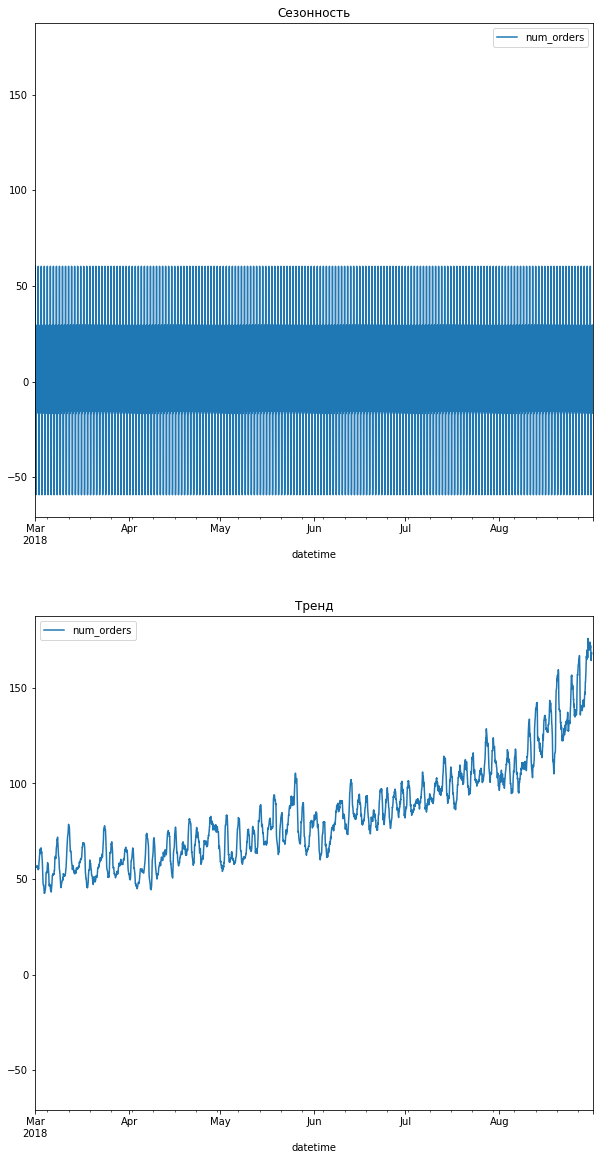

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharey=True)
decomposed.seasonal.plot(ax=ax[0])
decomposed.trend.plot(ax=ax[1])
ax[0].set_title('Сезонность')
ax[1].set_title('Тренд')
plt.show()

Для лучшего понимания данных построим график временного ряда. Также построим скользящее среднее.

In [14]:
taxi['roll_mean'] = taxi['num_orders'].rolling(10).mean() # размер окна 10
taxi['roll_std'] = taxi['num_orders'].rolling(10).std() # размер окна 10

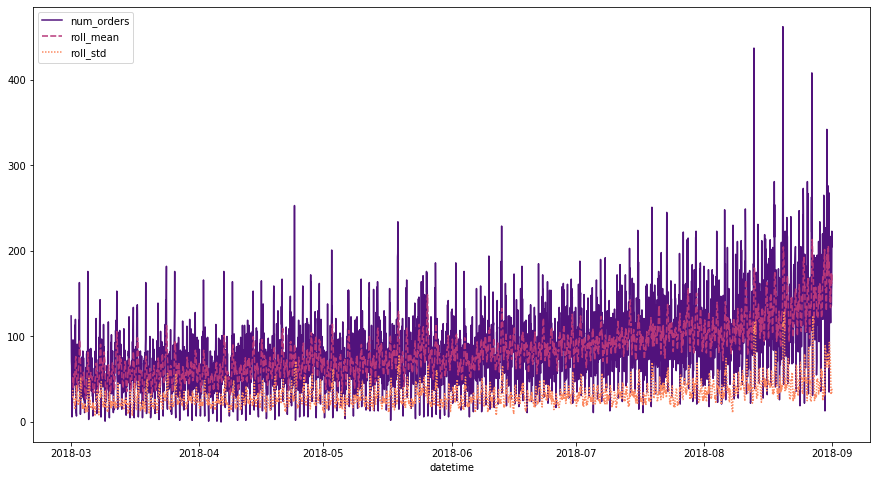

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=taxi, palette='magma', ax=ax)
plt.show()

По графику можно сделать следующие выводы:
1. наблюдается тренд увеличения заказов со временем;
2. дисперсия и среднее значения меняются в зависимости от времения, а значит ряд является нестационарным;
3. отсутствует сезонность.

Преобразуем данный временной ряд в стационарный с помощью разности вр. ряда.

In [16]:
taxi_stat = taxi - taxi.shift()

In [17]:
taxi_stat['roll_mean'] = taxi_stat['num_orders'].rolling(10).mean() # размер окна 10
taxi_stat['roll_std'] = taxi_stat['num_orders'].rolling(10).std() # размер окна 10

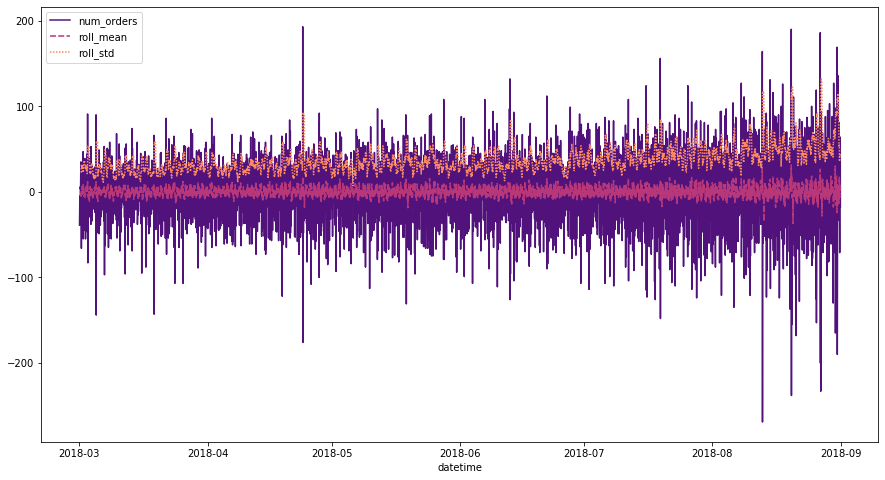

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=taxi_stat, palette='magma', ax=ax)
plt.show()

## Обучение

Перед обучением создадим признаки для временного ряда.

In [19]:
def make_features(data, max_lag, rolling_mean_size, target):
    data['year'] = data.index.year
    data['month'] = data.index.month
    #data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target].shift(lag)

    data['rolling_mean'] = data[target].shift(1).rolling(rolling_mean_size).mean()
    
    return data

In [20]:
def train_test_time_series(data, test_size, max_lag, rolling_mean_size):
    data_feat = make_features(data, max_lag, rolling_mean_size, 'num_orders')
    
    if 'roll_mean' in data.columns.tolist() and 'roll_std' in data.columns.tolist():
        data_feat.drop(['roll_mean', 'roll_std'], axis=1, inplace=True)

    train, test = train_test_split(data_feat, test_size=test_size, shuffle=False, random_state=7)
    train = train.dropna()
    X_train = train.drop('num_orders', axis=1)
    y_train = train['num_orders']
    X_test = test.drop('num_orders', axis=1)
    y_test = test['num_orders']
    
    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = train_test_time_series(taxi, 0.1, 1, 1)

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

Рассмотрим модели линейной регресии, случайного леса, ближайших соседей и градиентного бустинга. Отберем лучшую модель, а потом подберем оптимальное количество признаков.

In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### kNN

In [24]:
neighbors = list(range(2, 25, 1))
p_list = [1, 2, 3, 4]

In [25]:
rmse_neighbor = []
rmse_p = []

for neighbor in neighbors:
    model = KNeighborsRegressor(n_neighbors=neighbor, weights='distance')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse_neighbor.append(rmse(y_valid, y_pred))
    
for p in p_list:
    model = KNeighborsRegressor(p=p, weights='distance')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse_p.append(rmse(y_valid, y_pred))

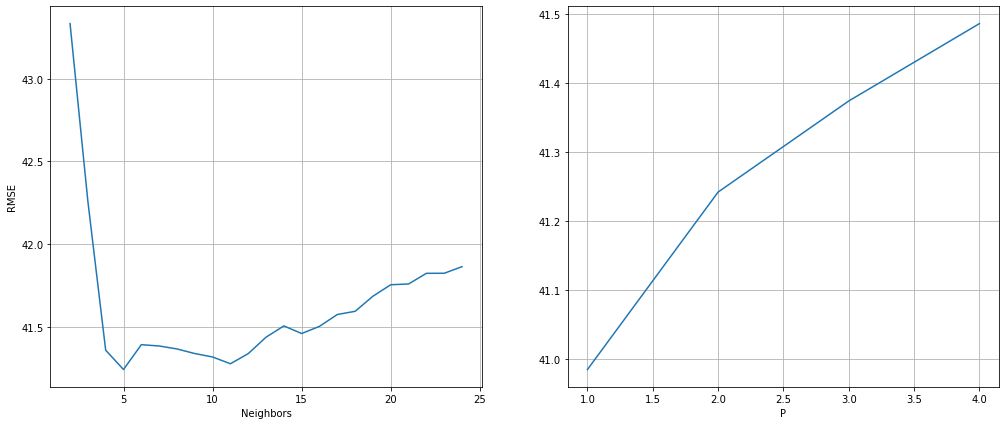

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

sns.lineplot(x=neighbors, y=rmse_neighbor, ax=ax[0])
sns.lineplot(x=p_list, y=rmse_p, ax=ax[1])

ax[1].set_xlabel('P')
ax[0].set_xlabel('Neighbors')
ax[0].set_ylabel('RMSE')
ax[0].grid()
ax[1].grid()
plt.show()

Оптимальными гиперпараметрами для kNN являются:
- n_neighbors=5;
- p=1.

In [27]:
knn = KNeighborsRegressor(n_neighbors=5, p=1, weights='distance')

In [28]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                    weights='distance')

In [29]:
y_pred = knn.predict(X_valid)

In [30]:
rmse(y_valid, y_pred)

40.98521361258387

### Linear Regression

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
y_pred = lr.predict(X_valid)

In [33]:
rmse(y_valid, y_pred)

39.288204171236934

### Random Forest

In [34]:
estimators = list(range(4, 100, 2))
depths = list(range(2, 16, 2))
features = list(range(1, len(X_train.columns.tolist()), 1))

In [35]:
rmse_estimator = []
rmse_depth = []
rmse_feat = []

for estimator in estimators:
    model = RandomForestRegressor(n_estimators=estimator, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse_estimator.append(rmse(y_valid, y_pred))
    
for depth in depths:
    model = RandomForestRegressor(max_depth=depth, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse_depth.append(rmse(y_valid, y_pred))

for feat in features:
    model = RandomForestRegressor(max_features=feat, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse_feat.append(rmse(y_valid, y_pred))

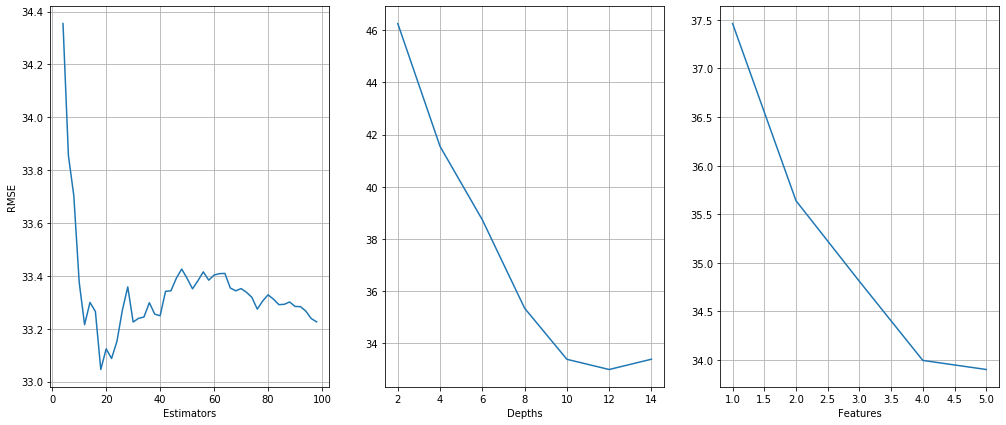

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

sns.lineplot(x=estimators, y=rmse_estimator, ax=ax[0])
sns.lineplot(x=depths, y=rmse_depth, ax=ax[1])
sns.lineplot(x=features, y=rmse_feat, ax=ax[2])

ax[2].set_xlabel('Features')        
ax[1].set_xlabel('Depths')
ax[0].set_xlabel('Estimators')
ax[0].set_ylabel('RMSE')
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

Оптимальными гиперпараметрами для Random Forest являются:
- n_estimators=19;
- max_depth=12;
- max_features=5.

In [37]:
rf = RandomForestRegressor(n_estimators=19, max_depth=12, max_features=5)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=19,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [38]:
y_pred = rf.predict(X_valid)

In [39]:
rmse(y_valid, y_pred)

34.16046458278006

## Тестирование

Получаем, что лучшее качество по метрике RMSE на валидационной выборке показала модель случайного леса. Воозьмем ее за финальную модель.

In [40]:
lags = list(range(1, 10, 1))
windows = list(range(1, 20))

In [41]:
rmse_lag = []
rmse_window = []

for lag in lags:
    X_train, X_test, y_train, y_test = train_test_time_series(taxi, 0.1, lag, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=7)    
    model = RandomForestRegressor(n_estimators=19, max_depth=12, max_features=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse_lag.append(rmse(y_valid, y_pred))
    
for window in windows:
    X_train, X_test, y_train, y_test = train_test_time_series(taxi, 0.1, 1, window)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=7)    
    model = RandomForestRegressor(n_estimators=19, max_depth=12, max_features=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse_window.append(rmse(y_valid, y_pred))

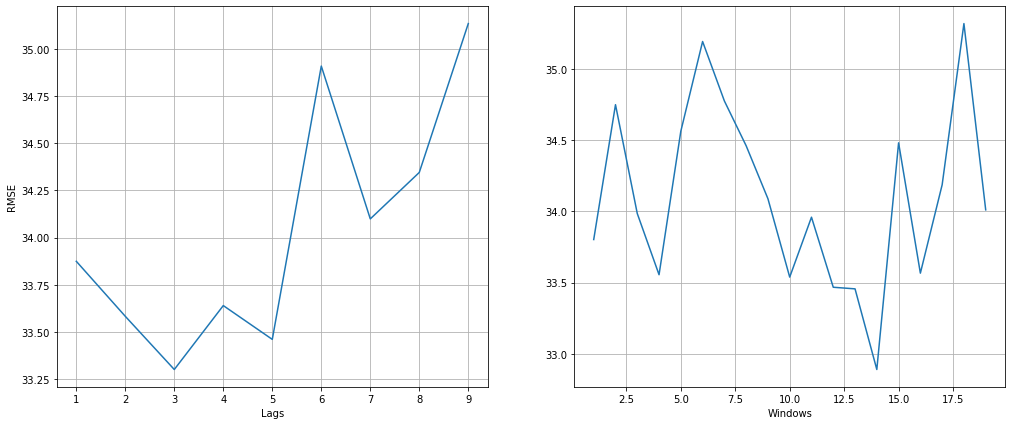

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

sns.lineplot(x=lags, y=rmse_lag, ax=ax[0])
sns.lineplot(x=windows, y=rmse_window, ax=ax[1])

ax[1].set_xlabel('Windows')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('RMSE')
ax[0].grid()
ax[1].grid()
plt.show()

In [47]:
X_train, X_test, y_train, y_test = train_test_time_series(taxi, 0.1, 3, 13)

In [48]:
rf = RandomForestRegressor(n_estimators=19, max_depth=12, max_features=5)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=19,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
y_pred = rf.predict(X_test)

In [50]:
rmse(y_test, y_pred)

46.70053953043389